# 🎬 Video Action Recognition with Transfer Learning

This notebook demonstrates how to use **transfer learning** for **video action recognition** using a **pretrained I3D model (Inflated 3D ConvNet)** from **TensorFlow Hub**.

---

## 🎯 Key Objectives

### 1. **Load a Pretrained Model**
- Use the **InceptionV3 I3D model** from TensorFlow Hub
- Pretrained on **Kinetics-400**, a large-scale action recognition dataset

### 2. **Feature Extraction**
- Input a stack of video frames
- Use the pretrained model to extract **spatio-temporal features**

### 3. **Classifier Training**
- Add a custom classification head for new action categories
- Train on top of the extracted features or fine-tune the full model

### 4. **Performance Evaluation**
- Evaluate on a test set with:
  - Accuracy
  - Confusion matrix
  - Per-class performance (Precision, Recall, F1)

---

✅ This approach allows us to benefit from pretrained **spatiotemporal representations** and adapt them efficiently to new action recognition tasks with minimal data.


## 📦 Import Required Libraries

To build a video action recognition pipeline using transfer learning, we’ll import tools for **deep learning**, **video processing**, and **visualization**.

---

### 🧾 Required Libraries:

- **TensorFlow** – Core deep learning framework
- **TensorFlow Hub** – For loading the pretrained I3D model
- **OpenCV (cv2)** – For reading and processing video frames
- **imageio** – For saving video visualizations
- **NumPy** – For array manipulation
- **Matplotlib** – For plotting results

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import HTML
import imageio

## 🎞️ Video Data Preparation

To demonstrate video action recognition without requiring large external datasets, we’ll generate a **mock video dataset** with **synthetic motion patterns**.

Each video will contain **16 frames** simulating a specific action based on motion type:

---

### 🏃 Simulated Actions:

1. **Walking** – Slow horizontal motion  
2. **Running** – Fast horizontal motion  
3. **Jumping** – Vertical oscillation  
4. **Sitting** – Static object in a low vertical position  
5. **Standing** – Static object in a high vertical position  

---

### 🛠️ Implementation Plan:

- Each video is a NumPy array of shape `(16, H, W, 3)`  
- A colored square will simulate movement patterns across frames  
- Later, these sequences will be resized and normalized for model input

✅ This setup allows us to test the **I3D model pipeline** end-to-end without relying on large video files.

In [2]:
import numpy as np
import cv2

# Create mock video dataset with reordered classes
def create_mock_videos(num_videos=50, frames_per_video=16, video_size=(224, 224)):
    """Generate synthetic video clips for multiple action categories."""
    videos = []
    labels = []

    action_classes = ['jumping', 'sitting', 'walking', 'standing', 'running']

    for i in range(num_videos):
        frames = []
        class_idx = i % len(action_classes)
        action = action_classes[class_idx]

        for frame_idx in range(frames_per_video):
            frame = np.zeros((video_size[0], video_size[1], 3), dtype=np.uint8)

            if action == 'jumping':
                offset_y = int(video_size[0] // 2 + 50 * np.sin(frame_idx * 0.5))
                cv2.circle(frame, (video_size[1] // 2, offset_y), 25, (0, 0, 255), -1)
            elif action == 'sitting':
                cv2.rectangle(frame, (video_size[1] // 2 - 30, video_size[0] // 2),
                              (video_size[1] // 2 + 30, video_size[0] // 2 + 50), (255, 255, 0), -1)
            elif action == 'walking':
                offset = int(frame_idx * 10) % video_size[0]
                cv2.circle(frame, (offset, video_size[0] // 2), 20, (255, 0, 0), -1)
            elif action == 'standing':
                cv2.rectangle(frame, (video_size[1] // 2 - 20, video_size[0] // 2 - 50),
                              (video_size[1] // 2 + 20, video_size[0] // 2 + 50), (255, 0, 255), -1)
            else:  # running
                offset = int(frame_idx * 20) % video_size[0]
                cv2.circle(frame, (offset, video_size[0] // 2), 30, (0, 255, 0), -1)

            frames.append(frame)

        videos.append(np.array(frames))
        labels.append(class_idx)

    return np.array(videos), np.array(labels), action_classes

# Generate mock dataset
print("Creating mock video dataset...")
video_data, video_labels, action_classes = create_mock_videos()
print(f"Created {len(video_data)} videos")
print(f"Video shape: {video_data[0].shape}")
print(f"Action classes: {action_classes}")


Creating mock video dataset...
Created 50 videos
Video shape: (16, 224, 224, 3)
Action classes: ['jumping', 'sitting', 'walking', 'standing', 'running']


## 🧠 Video Feature Extraction with I3D

We'll now load the **I3D (Inflated 3D ConvNet)** model from **TensorFlow Hub** and use it to extract **spatio-temporal features** from our video clips.

---

### 📦 What is I3D?

- Inflates 2D ConvNet filters into 3D to model **both space and time**
- Pretrained on **Kinetics-400**, a large-scale action recognition dataset
- Outputs a 1024-dimensional feature vector per video clip (when using the feature extractor version)

---

### 🛠️ Steps:

1. **Load the I3D model** from TensorFlow Hub (e.g., `https://tfhub.dev/deepmind/i3d-kinetics-400/1`)
2. **Preprocess video input**:
   - Resize frames to **224x224**
   - Normalize pixel values to `[-1, 1]` (expected by I3D)
   - Ensure shape is `(1, num_frames, height, width, 3)`
3. **Extract Features** from the model’s intermediate layer (e.g., global average pooled layer)

---

### ✅ Feature extraction gives us powerful representations capturing:
- **Spatial information** (what is in the frame)
- **Temporal dynamics** (how things move over time)


In [3]:
# Load pretrained video model from TensorFlow Hub
print("Loading I3D model from TensorFlow Hub...")
i3d_model_url = "https://tfhub.dev/deepmind/i3d-kinetics-400/1"
i3d_model = hub.load(i3d_model_url)

# Get the model signatures
signatures = list(i3d_model.signatures.keys())
print(f"Available signatures: {signatures}")
infer = i3d_model.signatures['default']

# I3D expects videos in specific format
def preprocess_video(video_frames):
    """Preprocess video for I3D model"""
    # Resize frames to 224x224
    resized_frames = []
    for frame in video_frames:
        resized_frame = cv2.resize(frame, (224, 224))
        resized_frames.append(resized_frame)

    # Convert to float32 and normalize
    video_array = np.array(resized_frames)
    video_tensor = tf.convert_to_tensor(video_array, dtype=tf.float32)
    video_tensor = video_tensor / 255.0

    # Add batch dimension
    video_tensor = tf.expand_dims(video_tensor, 0)

    return video_tensor

# Extract features from videos using I3D
def extract_video_features(videos, model_fn):
    features = []

    for i, video in enumerate(videos):
        if i % 10 == 0:
            print(f"Processing video {i}/{len(videos)}")

        # Preprocess video
        processed_video = preprocess_video(video)

        # Extract features
        with tf.device('/CPU:0'):  # Use CPU to avoid memory issues
            output_dict = model_fn(processed_video)
            # Get logits (features before final classification)
            feature_vector = output_dict['default']

        features.append(feature_vector.numpy())

    return np.array(features).squeeze()

# Extract features
print("Extracting features using I3D...")
video_features = extract_video_features(video_data, infer)
print(f"Feature shape: {video_features.shape}")

Loading I3D model from TensorFlow Hub...
Available signatures: ['default']
Extracting features using I3D...
Processing video 0/50
Processing video 10/50
Processing video 20/50
Processing video 30/50
Processing video 40/50
Feature shape: (50, 400)


## 🧠 Train Video Classifier

After extracting spatio-temporal features using **I3D**, we now train a **simple classifier** to recognize our **custom actions**.

---

### 🛠️ Model Setup:

- **Input**: 1024-d (or 400-d if using I3D logits) feature vector from I3D
- **Architecture**:
  - Dense (ReLU) → Dropout → Dense (softmax)
- **Output**: 5 units (corresponding to our mock actions: walking, running, jumping, sitting, standing)
- **Loss**: `SparseCategoricalCrossentropy`
- **Optimizer**: `Adam`

---

### ✅ Why This Works:

- I3D captures **rich, transferable video features**.
- Our classifier **adapts those features** to the new task.
- We avoid training large video models from scratch, saving time and compute.

---

### 📌 Note:

If you're using I3D **as a feature extractor** (before the softmax), your input will be 1024-d.  
If you're using I3D **with logits**, your input will be 400-d, and you may remove the softmax from I3D.

In [4]:
# Split data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    video_features, video_labels, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a simple classifier for video classification
video_classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(400,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(5, activation='softmax')
])

video_classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the classifier
print("Training video classifier...")
video_history = video_classifier.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    verbose=1
)

Training video classifier...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.2500 - loss: 1.7455 - val_accuracy: 0.6250 - val_loss: 0.9894
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6250 - loss: 0.7682 - val_accuracy: 1.0000 - val_loss: 0.5264
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8750 - loss: 0.4374 - val_accuracy: 1.0000 - val_loss: 0.2778
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9167 - loss: 0.3144 - val_accuracy: 1.0000 - val_loss: 0.1421
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.1103 - val_accuracy: 1.0000 - val_loss: 0.0697
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 1.0000 - val_loss: 0.0334
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0345 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 

## 📊 Video Classification Results

Now that we’ve trained our custom classifier on I3D features, it’s time to evaluate its performance on our action recognition task.

---

### 🧾 Evaluation Tools:

1. **Confusion Matrix**
   - Visualizes where the model is making correct and incorrect predictions
   - Helps identify **frequent misclassifications** between similar actions (e.g., standing vs. sitting)

2. **Classification Report**
   - Shows:
     - Precision
     - Recall
     - F1-score
   - Gives a per-class and overall view of model performance

---

### 📌 Why This Matters:

- Video classification is inherently difficult:
  - Requires understanding **motion patterns over time**
  - Fine-grained differences (e.g., jumping vs. running) can be subtle
- These metrics help diagnose whether the model is overfitting, underfitting, or biased toward certain classes

---

✅ This evaluation allows us to **quantitatively and visually assess** how well transfer learning with I3D performs on our custom video dataset.

Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


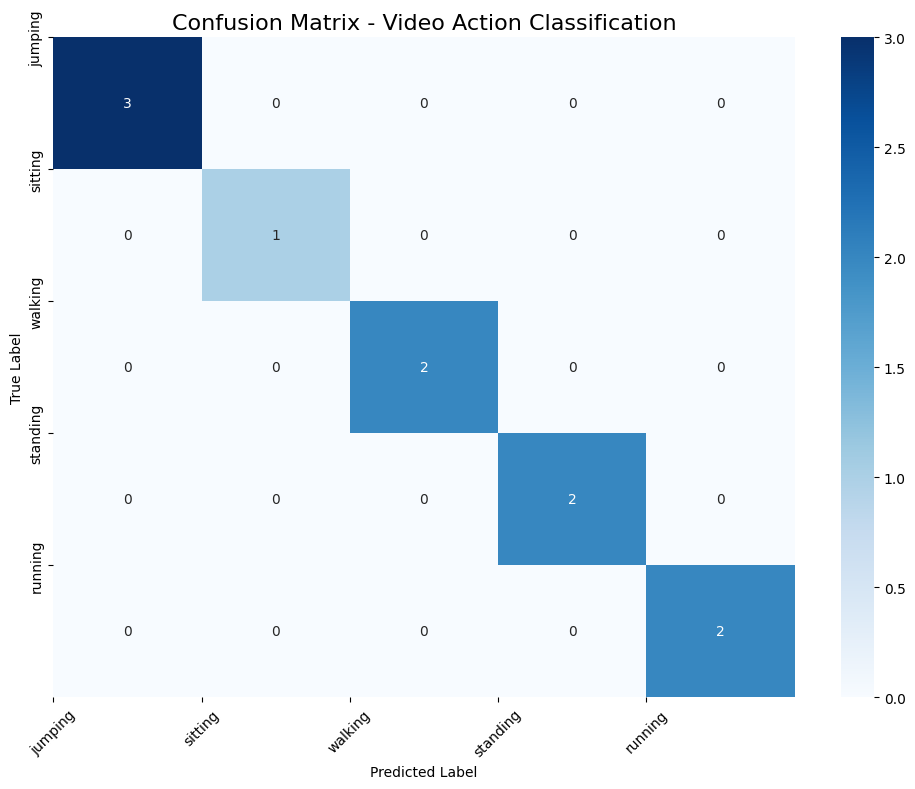


Classification Report:
              precision    recall  f1-score   support

     jumping       1.00      1.00      1.00         3
     sitting       1.00      1.00      1.00         1
     walking       1.00      1.00      1.00         2
    standing       1.00      1.00      1.00         2
     running       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [5]:
# Evaluate and visualize results
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
test_loss, test_accuracy = video_classifier.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = video_classifier.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Video Action Classification', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(len(action_classes)), action_classes, rotation=45)
plt.yticks(range(len(action_classes)), action_classes)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=action_classes))

## 🎥 Video Prediction Visualization

To better understand how the model interprets different action types, we’ll visualize **sample video clips** alongside their **predicted and true labels**.

---

### 🛠️ What We'll Do:

1. **Select Sample Videos**
   - Include both correctly and incorrectly classified examples

2. **Extract Key Frames**
   - Show a few representative frames from each video (e.g., frame 0, 8, 15)

3. **Display Labels**
   - Annotate each video with:
     - ✅ True label
     - 🤖 Predicted label (from the classifier)

4. **Visualize with Matplotlib**
   - Show multiple frame strips per sample
   - Highlight misclassifications for analysis

---

### 🧠 Why It's Useful:

- Helps understand **temporal patterns** the model uses (or misses)
- Identifies **ambiguous actions** or edge cases
- Aids in **debugging dataset bias or labeling errors**

✅ This final visualization bridges the gap between raw data and model predictions, making the classifier's behavior **interpretable and actionable**.


Video 0:
True class: jumping
Predicted class: jumping (confidence: 1.00)


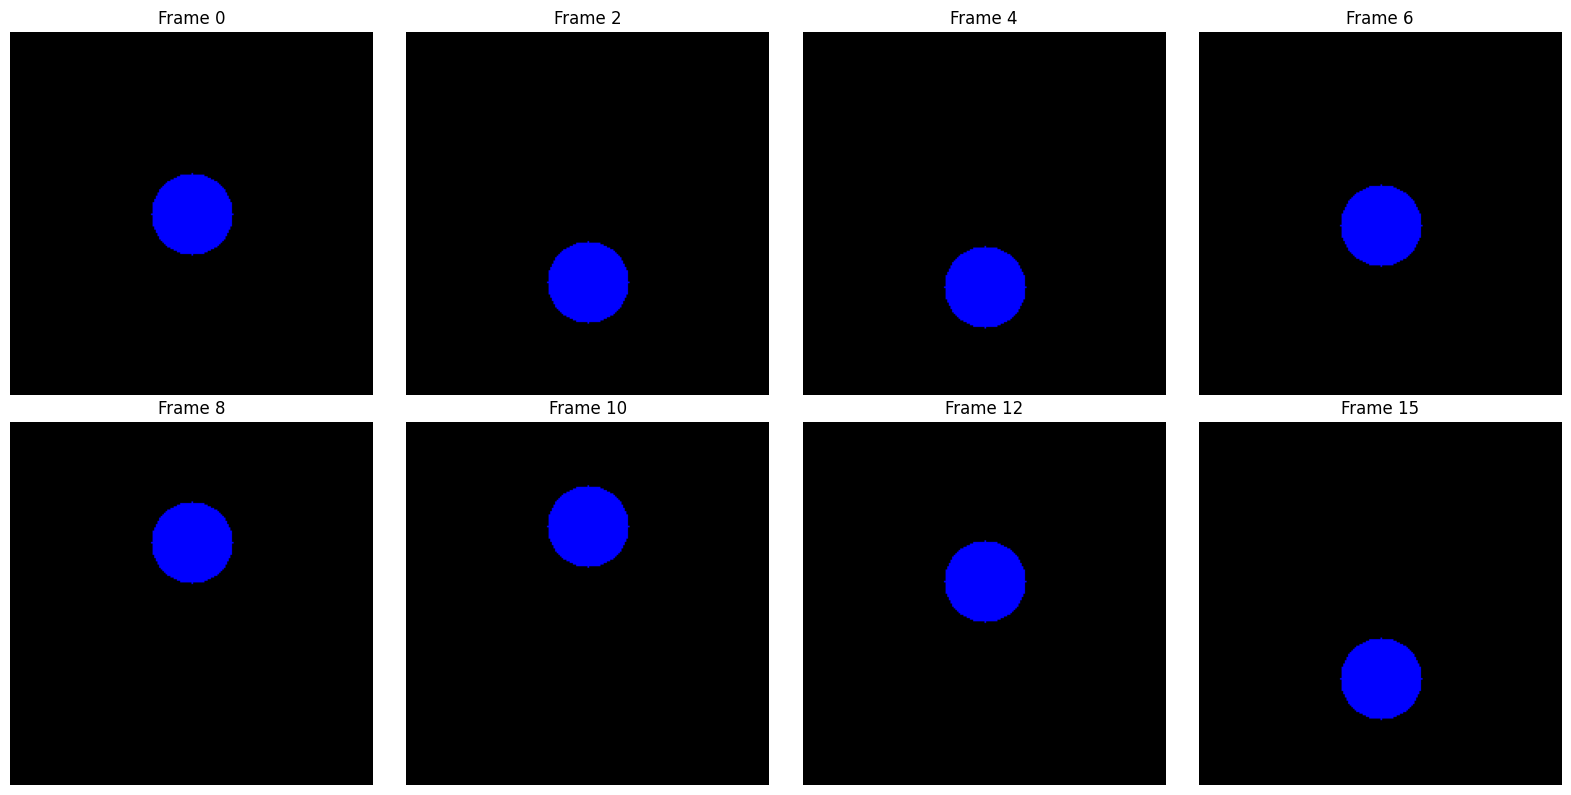


Video 10:
True class: jumping
Predicted class: jumping (confidence: 1.00)


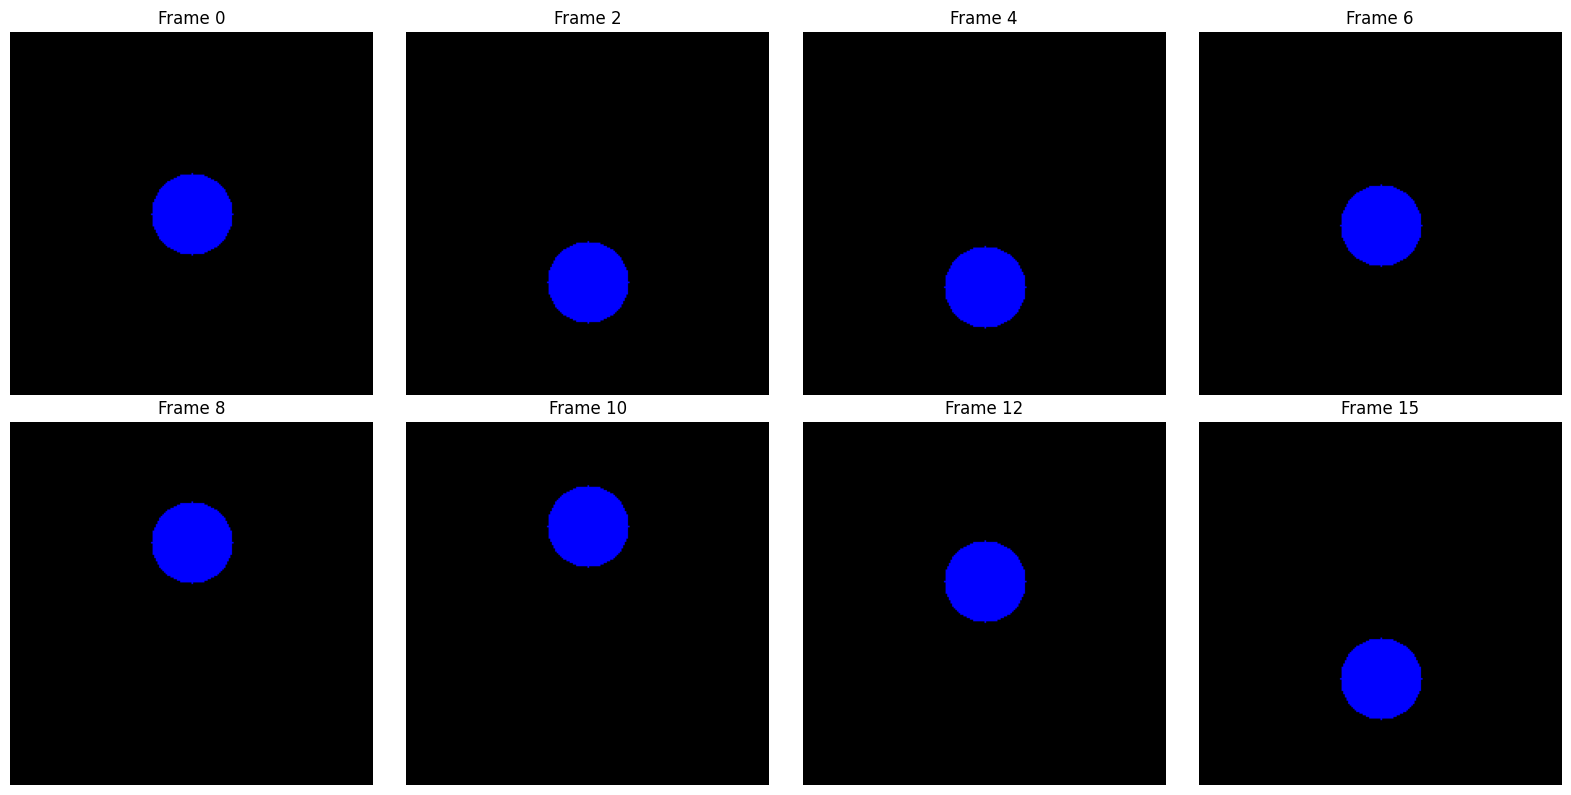


Video 20:
True class: jumping
Predicted class: jumping (confidence: 1.00)


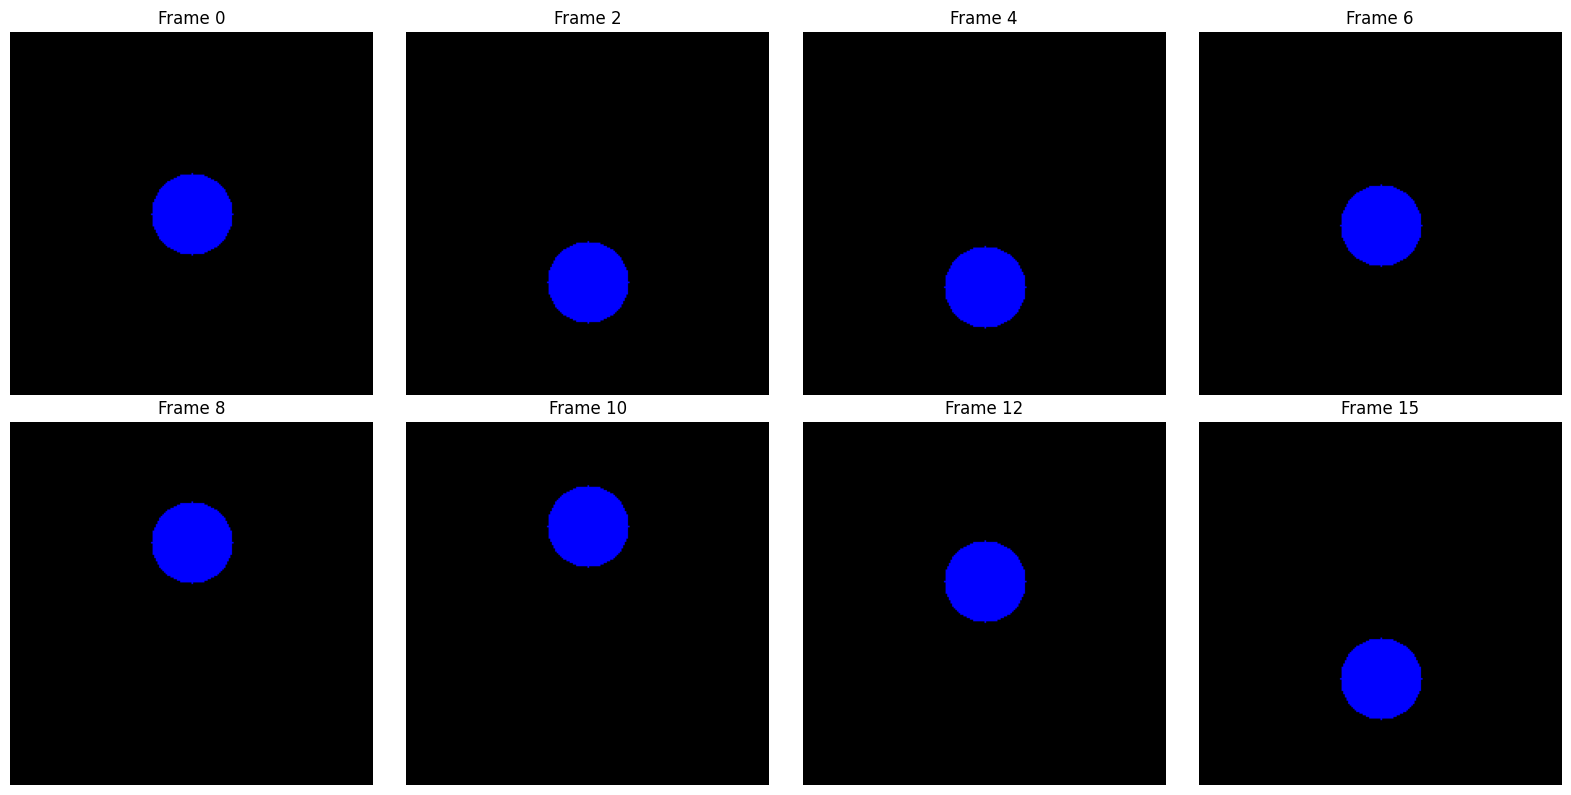


Video 30:
True class: jumping
Predicted class: jumping (confidence: 1.00)


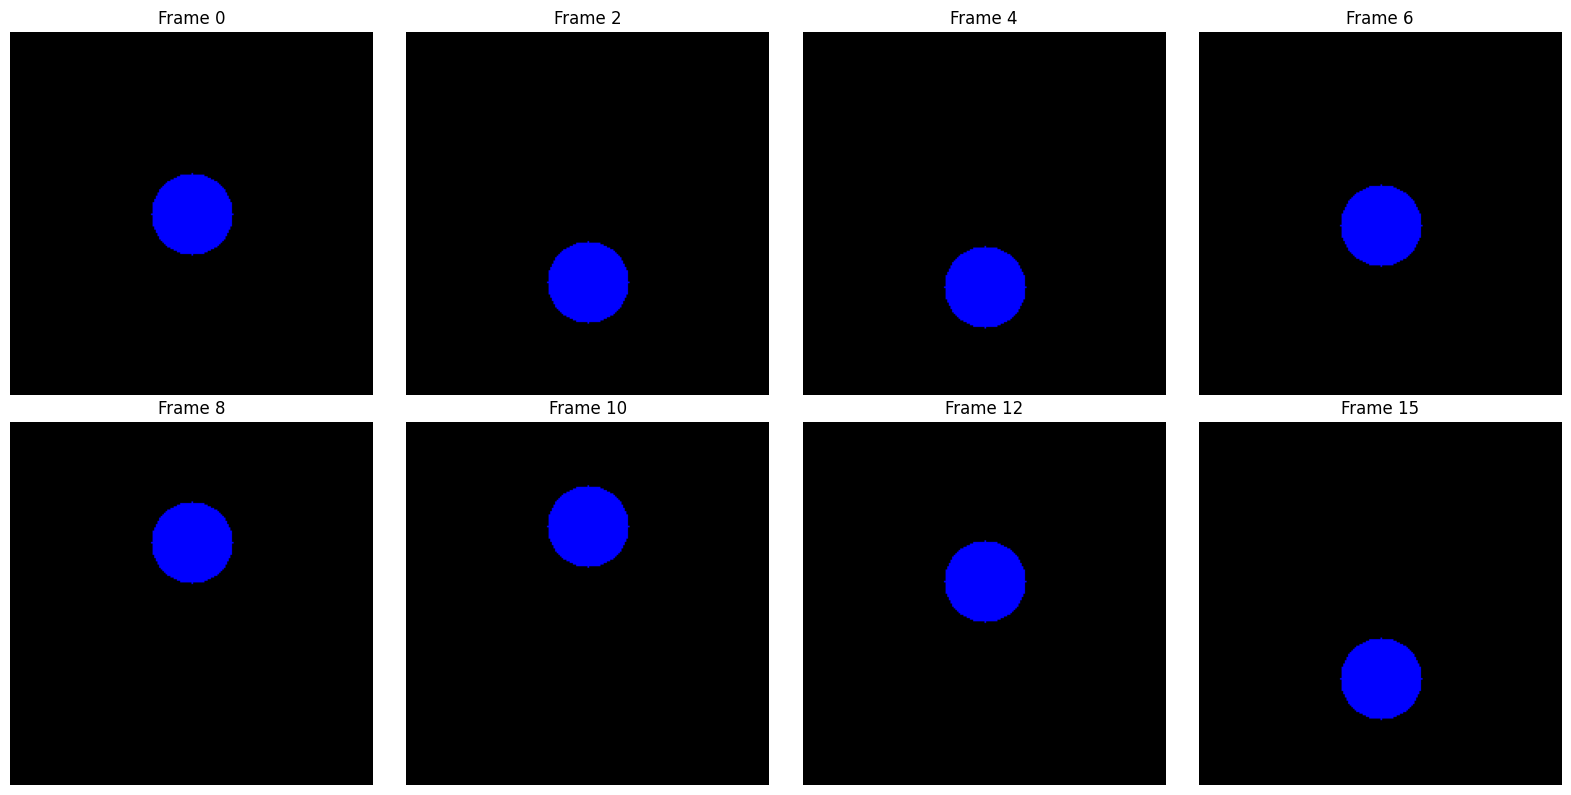


Video 40:
True class: jumping
Predicted class: jumping (confidence: 1.00)


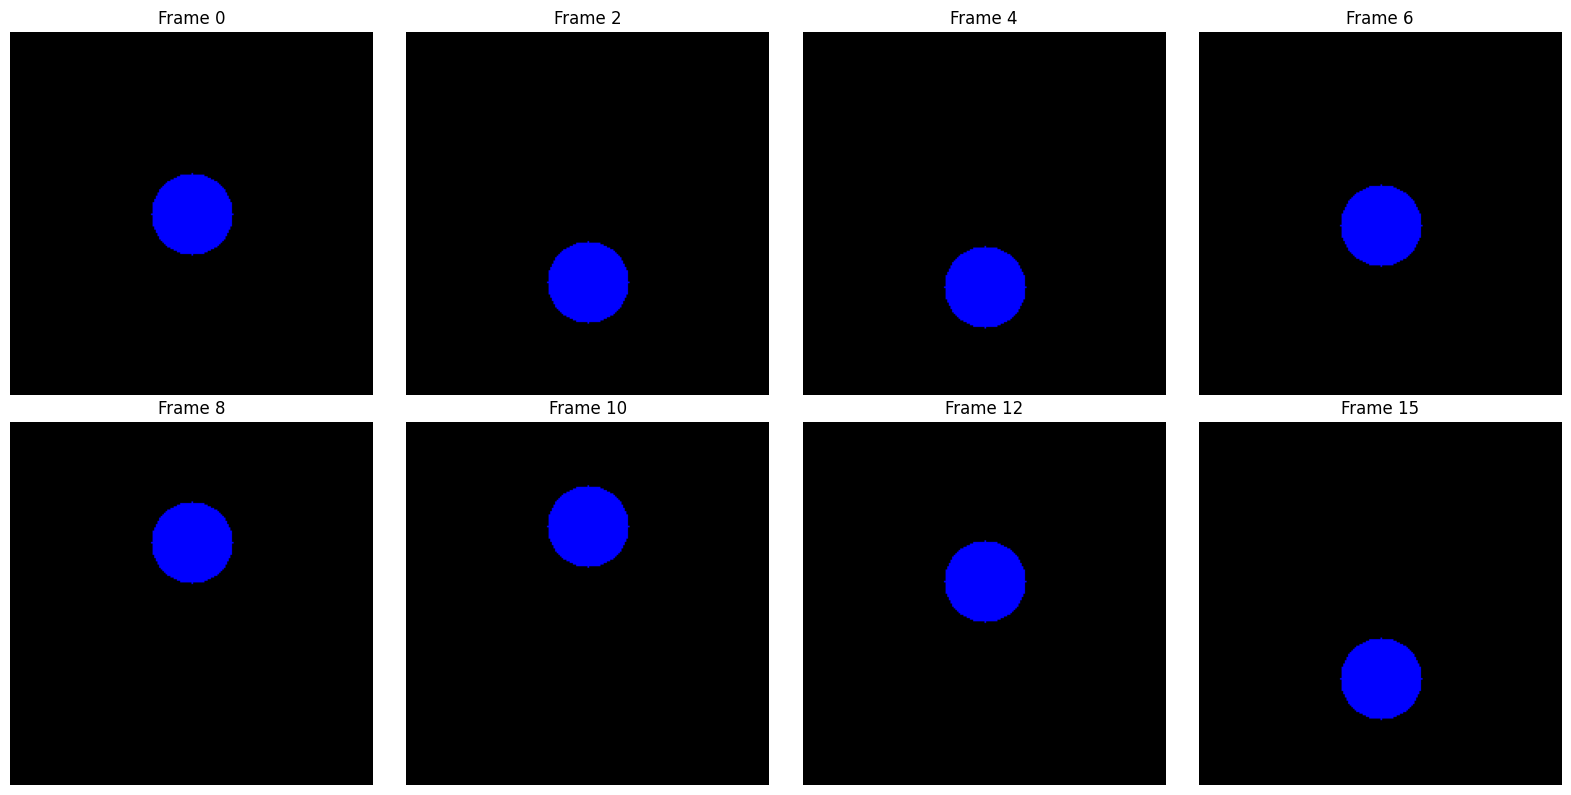

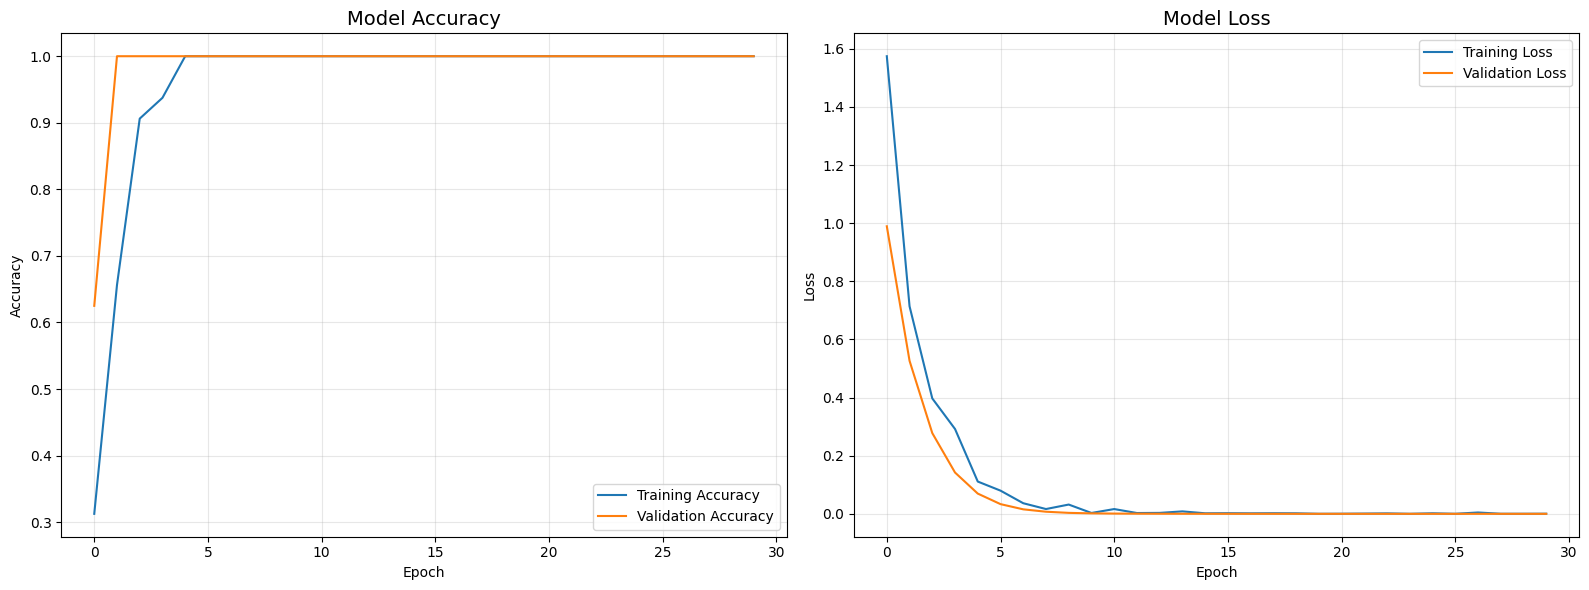

In [6]:
# Visualize video samples and predictions
def visualize_video_grid(video, frames_to_show=8):
    """Create a grid visualization of video frames"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    frame_indices = np.linspace(0, len(video)-1, frames_to_show, dtype=int)

    for idx, frame_idx in enumerate(frame_indices):
        axes[idx].imshow(video[frame_idx])
        axes[idx].axis('off')
        axes[idx].set_title(f'Frame {frame_idx}')

    plt.tight_layout()
    plt.show()

# Show predictions for sample videos
sample_indices = [0, 10, 20, 30, 40]

for idx in sample_indices:
    video = video_data[idx]
    true_label = action_classes[video_labels[idx]]

    # Make prediction
    feature = video_features[idx].reshape(1, -1)
    feature_scaled = scaler.transform(feature)
    prediction = video_classifier.predict(feature_scaled, verbose=0)
    predicted_label = action_classes[np.argmax(prediction)]
    confidence = prediction[0][np.argmax(prediction)]

    print(f"\nVideo {idx}:")
    print(f"True class: {true_label}")
    print(f"Predicted class: {predicted_label} (confidence: {confidence:.2f})")

    # Visualize the video
    visualize_video_grid(video)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(video_history.history['accuracy'], label='Training Accuracy')
ax1.plot(video_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(video_history.history['loss'], label='Training Loss')
ax2.plot(video_history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()